## Multi-class Image Classification Model

In this notebook, I begin exploring the TensorFlow framework to apply a CNN model in predicting the level of severity score in my diabetic retinopathy dataset. The 5 classes in this dataset include scores from 0-4, 0 indicating no presence of diabetic retinopathy present and 4 inidicating proliferative diabetic retinopathy. Due to the small dataset and heavily imbalance of class in the data, I decide to alter the goal of my project to a binary classification model to simply detect diabetic retinopathy by combining classes 1-4. Although the dataset will continue to be imbalance and there is still a challenge of over fitting the model, there will be more images in the minority class for the model to train one. The binary classification model is completed in my Binary Classification Model notebook. 


In [2]:
## Add table of contents to markdown files 


## Data Loading 
I being by loading the JPEG images with their corresponding severity labels. Since the images are not a subdirectory in their corresponding classes, I manually loaded the images and join them with its corresponding labels using ```os.path.join``` and define a function to resize, normalize and split the training and testing sets instead of the automated ```tf.keras.utils.image_dataset_from_directory``` which creates includes preprocessing and spliting of the data automatically. 

In [4]:
import numpy as np 
import pandas as pd
import os # for file manipulation
import PIL # for image manipulation
from PIL import Image 
import matplotlib.pyplot as plt # for visualization
import tensorflow as tf # for deep learning
from keras.utils import to_categorical # for one-hot encoding
from sklearn.model_selection import train_test_split # for splitting the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator # for data augmentation
from tensorflow.keras.models import Sequential # for creating the model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalMaxPooling2D  # for creating the model
from tensorflow.keras.metrics import Precision, Recall, CategoricalCrossentropy # for model evaluation
from tensorflow.keras.applications import ResNet50 # for transfer learning

In [5]:
base_image_dir = os.path.join('/Users/shivanassori/Desktop/Folders/Data_Science_Units/Capstone/dataset/train')
image_dataset = pd.read_csv(os.path.join(base_image_dir, 'train_score_dec29.csv')) 
#the images are not annotated with classes, so we need to join the csv file with the image names and labels with the images in a single path. 


image_dataset['PatientId'] = image_dataset['image'].map(lambda x: x.split('_')[0]) #getting the image ID from the image name
image_dataset['path'] = image_dataset['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x))) #creating a new column and appending the full file path for each image. 

image_dataset['exists'] = image_dataset['path'].map(os.path.exists) #making sure that every image exists in the labels csv and the image itself. 


print(image_dataset['exists'].sum(), 'images found of', image_dataset.shape[0], 'total') #print how many images are found in the csv and images. 
image_dataset['eye'] = image_dataset['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0) #creating a binary column for left and right eye image. left = 1 and right =0. 

image_dataset['level_cat'] = image_dataset['level'].map(lambda x: to_categorical(x, 1+image_dataset['level'].max())) # creating a categorical column that includes one-hot encoded labels for the level of severity. 

image_dataset.dropna(inplace = True) 
image_dataset = image_dataset[image_dataset['exists']] #eliminate any labels to any images that are not found in the directory. 
image_dataset.sample(13)
#code obtained from: https://www.kaggle.com/code/kmader/inceptionv3-for-retinopathy-gpu-hr 

8406 images found of 8408 total


,image,level,PatientId,path,exists,eye,level_cat
6271,17792_right,0,17792,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
3795,1826_right,0,1826,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1739,11818_right,1,11818,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,"[0.0, 1.0, 0.0, 0.0, 0.0]"
6367,16907_right,2,16907,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,"[0.0, 0.0, 1.0, 0.0, 0.0]"
1611,14947_left,0,14947,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1429,15353_right,0,15353,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
8022,11156_right,2,11156,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,"[0.0, 0.0, 1.0, 0.0, 0.0]"
8276,11616_left,0,11616,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
4736,13113_right,0,13113,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
7632,11169_left,0,11169,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


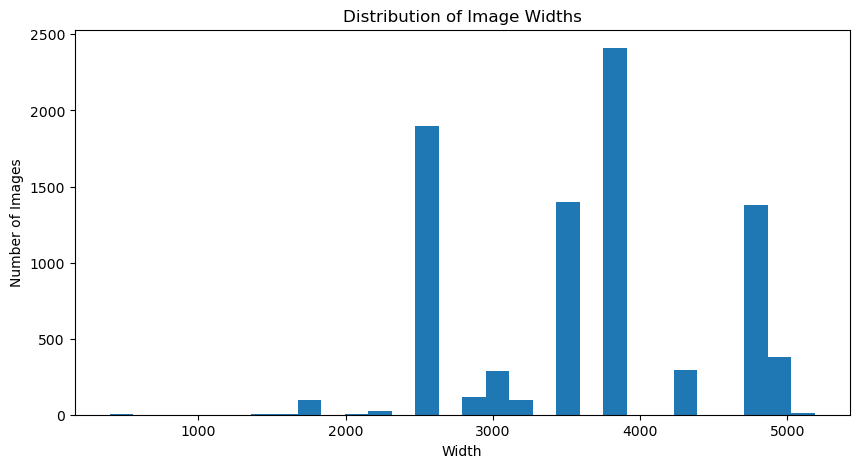

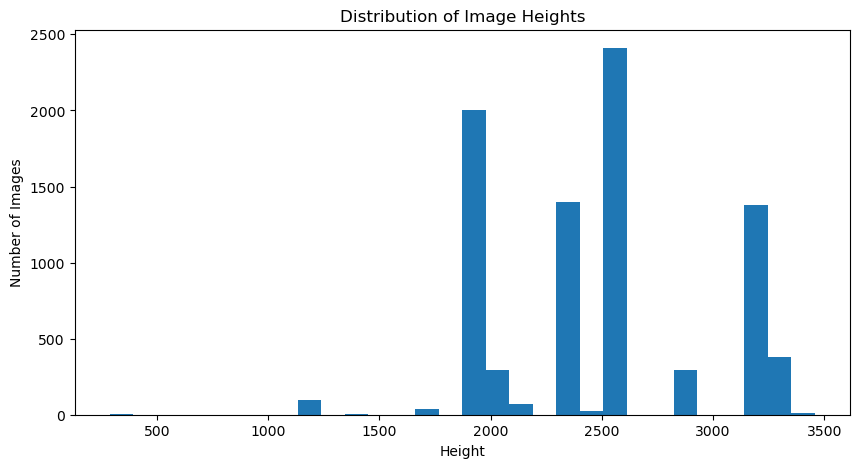

In [6]:
widths = []
heights = []
for img_path in image_dataset['path']:
    with Image.open(img_path) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# distribution of widths
plt.figure(figsize=(10, 5))
plt.hist(widths, bins=30)
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Number of Images')
plt.show()

# distribution of heights
plt.figure(figsize=(10, 5))
plt.hist(heights, bins=30)
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Number of Images')
plt.show()

In [7]:
# min and max of widths and heights
min_width, max_width = min(widths), max(widths)
min_height, max_height = min(heights), max(heights)
print(f"Minimum width: {min_width}, Maximum width: {max_width}")
print(f"Minimum height: {min_height}, Maximum height: {max_height}")

Minimum width: 400, Maximum width: 5184
Minimum height: 289, Maximum height: 3456


level
0    6148
2    1283
1     588
3     221
4     166
Name: count, dtype: int64


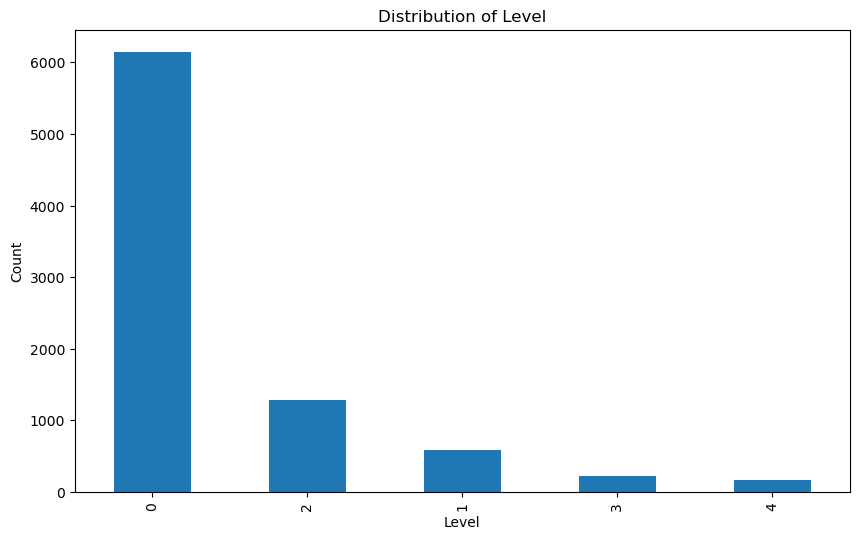

In [8]:
#looking into the distribution of the severity of the disease.
level_counts = image_dataset['level'].value_counts()
print(level_counts)

#plotting the distribution of the severity of the disease.
plt.figure(figsize=(10,6))
level_counts.plot(kind='bar')
plt.title('Distribution of Level')
plt.xlabel('Level')
plt.ylabel('Count')
plt.show()

In [6]:
#to confirm if every patient has both left and right eye images. 
eye_counts = image_dataset.groupby('PatientId')['eye'].nunique()
print(eye_counts[eye_counts == 1].index)

Index([], dtype='object', name='PatientId')


**Observation** 

The dataset includes 8406 valid JPEG images. Each ```PatientId``` had both left and right eye image with a corresponding score for each image. The images in the dataset have a wide range of sizes with a minimum width of 400 while the maximum width is 5184. Minimum and maximum height are respectively 289 and 3456. The distribution of the severity score is heavily skewed towards the 0 class. This is a common obstacle in training medical images due to the limited images available.

In [7]:
#This code saves the image dataset to a csv file. This will be used for other notebooks. 
image_dataset.to_csv('image_dataset.csv', index=False)

In [8]:
#checking again if all the images are valid 
def is_valid_image(img_path):
    try:
        img = Image.open(img_path)
        img.verify()  # verifies if the file is a valid image
        return True
    except (IOError, SyntaxError) as e: #if the image is not valid, it will print the image path and the error.
        print(f'Invalid image: {img_path} - {e}')
        return False
    
image_dataset['valid'] = image_dataset['path'].map(is_valid_image) #creating a new column that checks if the image is valid or not.

image_dataset = image_dataset[image_dataset['valid']] #eliminating any images that are not valid.

image_dataset.drop(columns=['valid'], inplace=True) #dropping the valid column as it is not needed anymore.

print(image_dataset['exists'].sum(), 'images found of', image_dataset.shape[0], 'total')


8406 images found of 8406 total


The following code views some of the images in the dataset. 

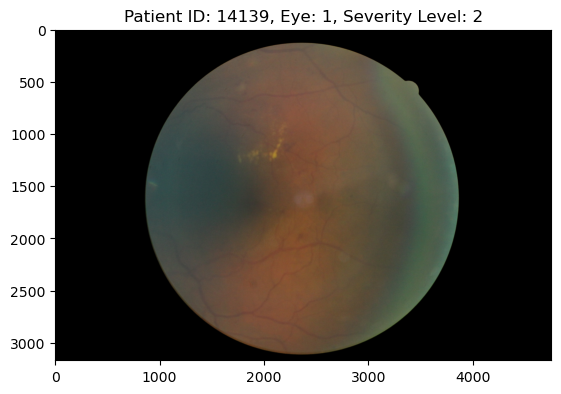

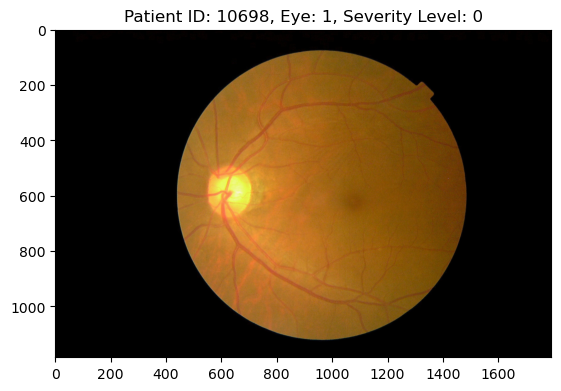

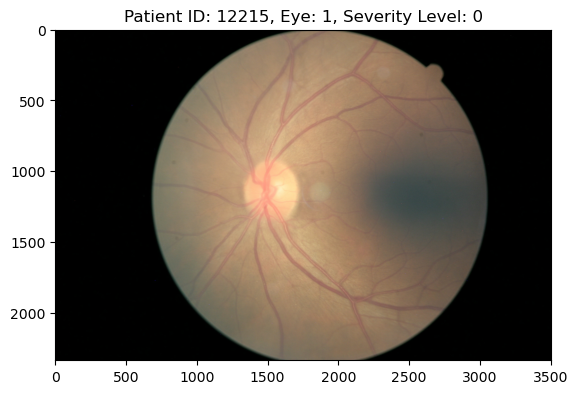

In [9]:
#viewing random images to for integrity check 
sample_indices = np.random.choice(image_dataset.index, size=3, replace=False)

for i in sample_indices:
    image = Image.open(image_dataset.loc[i, 'path'])
    plt.imshow(image)
    plt.title(f"Patient ID: {image_dataset.loc[i, 'PatientId']}, Eye: {image_dataset.loc[i, 'eye']}, Severity Level: {image_dataset.loc[i, 'level']}")
    plt.show()

The following code looks are some of the images that are classified as class 4, to see the visual difference in the images as compared to the other classes. This also shows the vast differences in resolution, brightness and angles of the images in the dataset. 

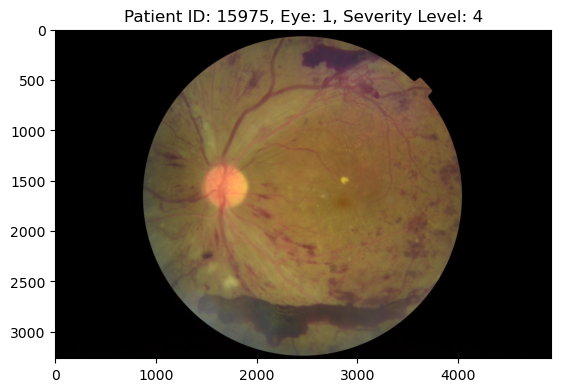

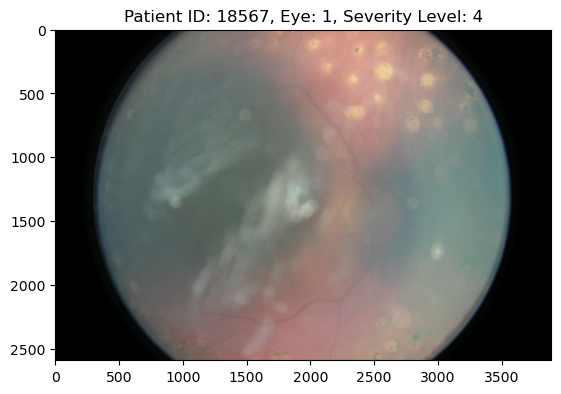

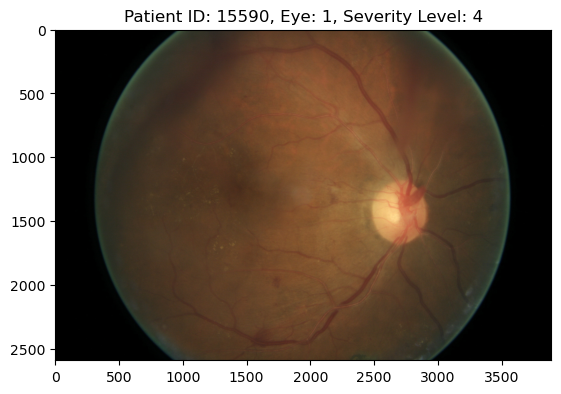

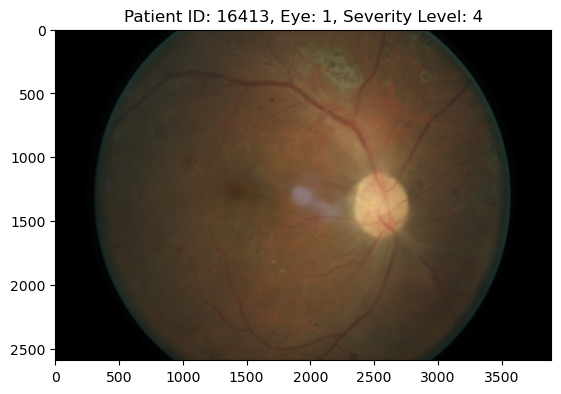

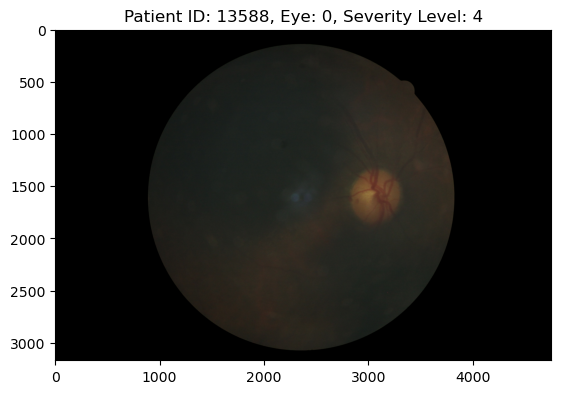

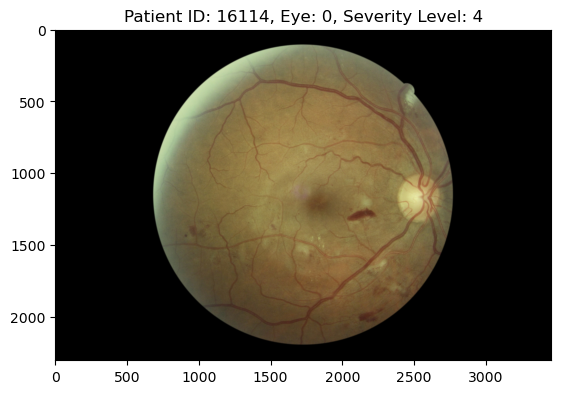

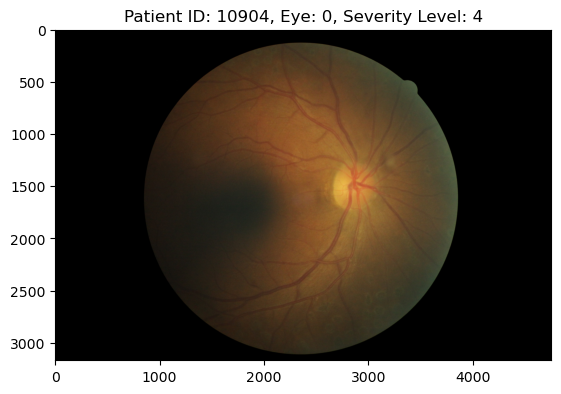

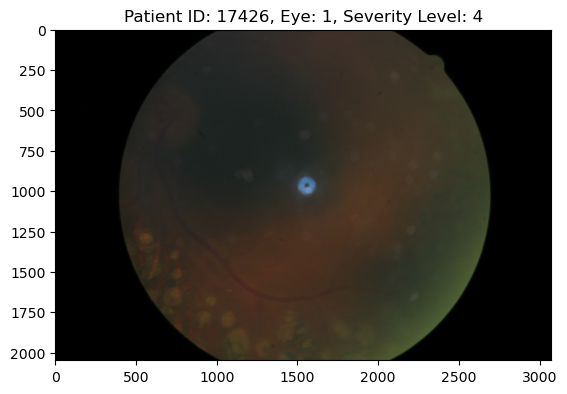

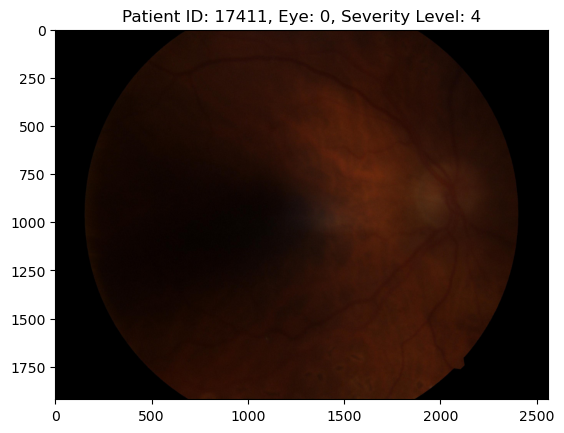

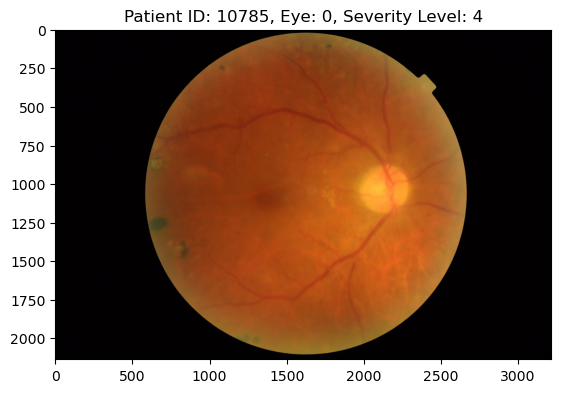

In [10]:
# filter the DataFrame to only include rows where 'level' is 4
filtered_dataset = image_dataset[image_dataset['level'] == 4]

# generate random indices from the filtered DataFrame
random_indices = np.random.choice(filtered_dataset.index, size=10, replace=False)

for i in random_indices:
    image = Image.open(filtered_dataset.loc[i, 'path'])
    plt.imshow(image)
    plt.title(f"Patient ID: {filtered_dataset.loc[i, 'PatientId']}, Eye: {filtered_dataset.loc[i, 'eye']}, Severity Level: {filtered_dataset.loc[i, 'level']}")
    plt.show()
    

## Train-Test Split

The target column in our model is ```level_cat```. In the TensorFlow framework, the target column needs to be in a numpy array because the model expects the input data to be in a numerical format that can be processed efficiently. Therefore, out one-hot encoded target is converted to a numpy array in the following code. Numpy arrays are more memory efficient and faster than Python lists and while training a model, TensorFlow uses the numerical representations to adjust the model's weight through backpropagation. 

In [11]:
y_array = np.array(list(image_dataset['level_cat']))

In [12]:
y_array

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [13]:
#splitting the dataset into training and remainder sets. The remainder set will be used for validation and testing. 
#Stratify is used to make sure that the distribution of the severity of the disease is the same in both the training and remainder sets.
X_train, X_rem, y_train, y_rem = train_test_split(image_dataset['path'],y_array, test_size = 0.2, random_state = 42, stratify = y_array)

In [14]:
#splitting the remainder set into validation and testing sets.
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, random_state = 42, stratify = y_rem)

In [15]:
type(X_train)

pandas.core.series.Series

Now that we have split our data into training, validation, and testing sets, we need to convert the sets into tensors before begining modeling. 
TensorFlow models require the data to be in the form of tensors because of the following reasons: 
1. Efficiency: Tensors are a generalization of matrices to higher dimensrions, and are the fundemental data structure in TensorFlow. 
2. Compatibility: In order to use the full range of TensorFlow's functionality the data needs to be in tensor format. 
3. Batch Processing: To perform batch processing which means that you can perform computations on an entire batch of data points at once, rather than looping over them one by one, the data needs to be in tensor format. This add to efficiency and a main reason why neural networks cna be trained so quickly. 

The following code takes the images and its corresponding label as input for the model. The function reads the ```image_path``` from the dataframe and returns a raw binary data of the image, then decodes the JPEG encoded image and converts the pixel values of the image from integers to floating point and scaling the values. Essentially, this function loads and normalizes the data as input. 

In [16]:
#function to take an image path and its corresponding label as input
#read the image file, decode and resize it, convert the pixel values to [0,1] by dividing by 255(normalizing)
def image_load_preprocessing(image_path, label): 
    image = tf.io.read_file(image_path) #tensorflow function that reads image file by image_path and returns a raw binary data of the image
    image = tf.image.decode_jpeg(image, channels =3) #decodes JPEG encoded image from the raw binary data, channel = 3 indicates the image is in color
    image = tf.image.resize(image,[299,299]) #ensuring all the images are the same size
    image = tf.cast(image, tf.float32)/255.0 # converts the pixel values of the image from integers to floating point and then scaling the pixel values
    return image, label


The following function performs image augmentation on the images. This is done to increase diversity and amount of training by including rotations and brightness of the images. This is done only on the training set. 

In [17]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image) #randomly flips the image horizontally
    image = tf.image.random_brightness(image, max_delta=0.5) #randomly changes the brightness of the image
    return image,label

The following cell was used to iterate through the image path and identify corrupted image in the testdataset. The corrupted image and its corresponding eye pair image were removed from the folder. 

In [18]:
#def check_image(image_path): 
    #try:
        #image = Image.open(image_path).convert('RGB')
        #image = image.resize((250, 250))
        #image = np.array(image)
        #image = tf.convert_to_tensor(image)
        #image = tf.cast(image, tf.float32)/255.0 
        #return True
    #except Exception as e:
        #print(f"Error processing image file {image_path}: {e}")
        #return False

#invalid_images = [image_path for image_path in X_test if not check_image(image_path)]

#X_test = [image_path for image_path in X_test if image_path not in invalid_images]

In [19]:
#converts the level_cat column which is an array to TensorFlow tensors
y_train_tf = tf.convert_to_tensor(y_train.tolist(), dtype=tf.float32)
y_val_tf = tf.convert_to_tensor(y_val.tolist(), dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test.tolist(), dtype=tf.float32)

In [20]:
#Creates tensorflow datasets from training and validation sets using from_tensor_slices method to create dataset of pairs(image_path, label)
#apply the image_load_preprocessing function to each element using 'map.'

train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train_tf))
train_dataset = train_dataset.map(image_load_preprocessing, num_parallel_calls = tf.data.experimental.AUTOTUNE)
#Applying data augmentation to the training dataset
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [21]:
#same thing with the other sets 
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val_tf))
val_dataset = val_dataset.map(image_load_preprocessing, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [22]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test_tf))
test_dataset = test_dataset.map(image_load_preprocessing, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [23]:
#shuffle the training dataset, batch it into batches of 32, prefetch batches to optimize performance. Same thing with the other set, except no shuffling because it is not necessary. 
#this creates a data loading pipeline when using a tensorflow dataset and apply batching, shuffling or other processes
#prefetching it asynchronously fetches the next batch of data in the background while the GPU/TPU is training on the current batch
#this is to optimize and reduce overall training time. 
#tf.data.experimental.AUTOTUNE ensures the data is selected at random orders for the learning process
batch_size = 16
train_dataset = train_dataset.shuffle(buffer_size = len(X_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [24]:
len(train_dataset)

421

In [25]:
len(val_dataset)

53

In [26]:
len(test_dataset)

53

## Modeling 
Now that we have our datasets in tensor format, our training set augmented we can begin the modeling process. The model in this notebook is a CNN (Convolutional Neural Network) model. CNNs are a class of deep learning models that are especially effective for processing grid-like data such as images. They are designed to automatically and adaptively learn spatial hierachies of features from the input data and they are a common approach to building models with medical images. The key components of a CNN are as follows: 
1. Convolutional layer: The core block of a CNN model. The layer's parameters consists of a set of learnable filters/kernels which have a small receptive field, but extend through the full depth of the input volume. During the forward pass, each filter is convolved across the width and height of the input volume, computing the dot product between the entries of the filter and the input and producing a 2D activation map of that filter. Eventually the network learns the filters that activate when it detects some specific type of feature at some spatial position in the input. 
2. Pooling layer: This layer progressively reduces the amount of parameters and computation in the network. Pooling layer operates on each feature map independently. 
3. Fully connected layer: Neurons in a fully connected layer have full connections to all activations in the previous layer. 
4. ReLU layer: The Rectified Linear Unit layer applies the relu activation elemntwise. It is a non-linear operation and does not change the dimenstions of the previous layer. 
5. Softmax/Sigmoid layer: At the end of a CNN model, a softmax or sigmoid activation function is typically used for the final classification, depending on how many classes are in the target.  

In [28]:
model = Sequential() #creating a sequential model

In [29]:
#adding layers to the model
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'valid', input_shape=(299, 299, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(32, activation = 'relu'))     
model.add(Dense(5, activation = 'softmax'))

In [30]:
#compiling the model, using adam optimizer, categorical crossentropy loss function and accuracy as the metric 
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics = ['accuracy']) 

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 32)        0

In [32]:
#sets up a tensorboard callback in TensorFlow's Keras API as a visualization tool that allows you to monitor and analyse
#various aspects of the machine learning model during training. 

logdir = '/Users/shivanassori/Desktop/Folders/Data_Science_Units/Capstone/logsdir'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [32]:
#fitting the model to the training dataset, using the validation dataset to validate the model.
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset)

Epoch 1/5


2024-01-30 19:51:11.552533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1048 of 6724
2024-01-30 19:51:21.587773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1985 of 6724
2024-01-30 19:51:41.557131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 3974 of 6724
2024-01-30 19:52:01.555598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 5892 of 6724
2024-01-30 19:52:10.196160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


421/421 [==============================] - 190s 288ms/step - loss: 0.9432 - accuracy: 0.7289 - val_loss: 0.8770 - val_accuracy: 0.7313
Epoch 2/5


2024-01-30 19:54:21.720996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 937 of 6724
2024-01-30 19:54:31.739091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1864 of 6724
2024-01-30 19:54:51.784301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 3662 of 6724
2024-01-30 19:55:11.725829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 5403 of 6724
2024-01-30 19:55:21.825302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 6211 of 6724
2024-01-30 19:55:28.242099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


421/421 [==============================] - 220s 340ms/step - loss: 0.8987 - accuracy: 0.7314 - val_loss: 0.8797 - val_accuracy: 0.7313
Epoch 3/5


2024-01-30 19:58:01.528633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 796 of 6724
2024-01-30 19:58:11.549115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1606 of 6724
2024-01-30 19:58:31.550946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 3254 of 6724
2024-01-30 19:58:41.571079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 3998 of 6724
2024-01-30 19:58:51.589460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4733 of 6724
2024-01-30 19:59:11.540845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a wh

421/421 [==============================] - 236s 348ms/step - loss: 0.8960 - accuracy: 0.7314 - val_loss: 0.8971 - val_accuracy: 0.7313
Epoch 4/5


2024-01-30 20:01:57.745093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 785 of 6724
2024-01-30 20:02:07.771176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1571 of 6724
2024-01-30 20:02:27.763562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 3168 of 6724
2024-01-30 20:02:47.792735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4721 of 6724
2024-01-30 20:03:07.830469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 6331 of 6724
2024-01-30 20:03:13.052053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


421/421 [==============================] - 236s 357ms/step - loss: 0.8861 - accuracy: 0.7314 - val_loss: 0.8892 - val_accuracy: 0.7313
Epoch 5/5


2024-01-30 20:05:53.783579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 727 of 6724
2024-01-30 20:06:03.808932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1522 of 6724
2024-01-30 20:06:23.823115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 3092 of 6724
2024-01-30 20:06:43.781885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4637 of 6724
2024-01-30 20:06:53.808103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 5405 of 6724
2024-01-30 20:07:10.553187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


421/421 [==============================] - 233s 347ms/step - loss: 0.8910 - accuracy: 0.7314 - val_loss: 0.9160 - val_accuracy: 0.7313


In [33]:
#saving the model
history.history

{'loss': [0.9431691765785217,
  0.8987143635749817,
  0.8959621787071228,
  0.8860560655593872,
  0.8909721374511719],
 'accuracy': [0.7288815975189209,
  0.7314098477363586,
  0.7314098477363586,
  0.7314098477363586,
  0.7314098477363586],
 'val_loss': [0.8769577145576477,
  0.8796873092651367,
  0.8971399664878845,
  0.8891701102256775,
  0.9160493016242981],
 'val_accuracy': [0.731272280216217,
  0.731272280216217,
  0.731272280216217,
  0.731272280216217,
  0.731272280216217]}

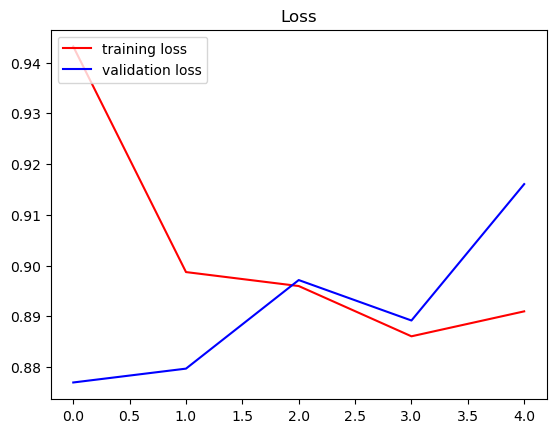

In [34]:
#plotting the accuracy of the model
plt.figure()
plt.plot(history.history['loss'], color = 'red', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

**Plot Observation** 

The plot of the loss function over epochs during the training can provide insights about the performance of the model on this dataset. The validation loss increases over epoch iteration while the training loss decreases, indicating over fitting of the model on the training set. The model is learning the training data too well and is not generalizing effectively to unseen data. 

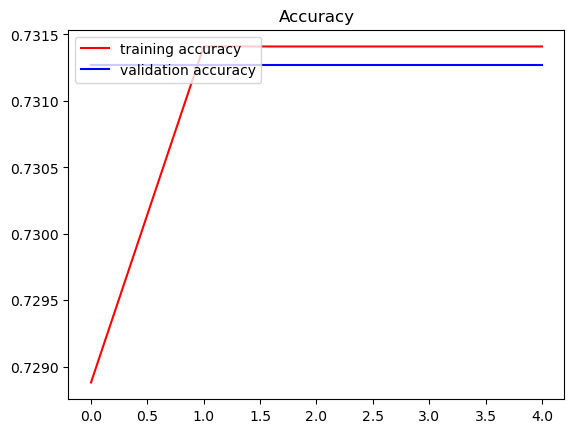

In [35]:
plt.figure()
plt.plot(history.history['accuracy'], color = 'red', label = 'training accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation accuracy')
plt.title('Accuracy')
plt.legend(loc = 'upper left')
plt.show()

**Plot Observation** 

An accuracy plot can visualize the performance of the model during training over successive epochs. We can observe that the training accuracy remains constant after the first epoch while the validation accuracy remains constant through-out. This might be an indication of low epoch number to truly validate that the accuracys will remain constant, but due to computaitonal resources we can observe that the model is not performing well on this dataset. 

In [39]:
#evaluating the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test accuracy: {test_accuracy}")

53/53 [==============================] - 11s 200ms/step - loss: 0.9146 - accuracy: 0.7313
Test accuracy: 0.731272280216217


Although the test accuracy is not very low, we have to take into account that 70% of our data set is of class 0, and the model is significantly learning those feautres and is not able to learn any significant information from the other classes. This obstable is common with imbalance of class. 

In [43]:
y_pred = np.argmax(predictions, axis=1)

In [44]:
type(y_pred)

numpy.ndarray

In [45]:
len(y_pred)

841

In [49]:
type(y_test_tf)

tensorflow.python.framework.ops.EagerTensor

## ResNet50


In this section, I explore ResNet50, which is a variant of ResNet model which has 50 layers deep. ResNet is a classic neural network used as a backbone for many computer vision tasks. The key innovation of ResNet is the introduction of 'skip connections' which allows the gradient to be directly backpropogated to earlier layers. The main benefit of this is that it helps to mitigate the problem of vanishing gradient, a common issue faced when training deep neural networks where the gradient becomes too small for training to be effective. 
ResNet50 is commonly used for image classification and recognition tasks. In this notebook I will explore using ResNet50 as a feature extractor by freezing the base model to keep the learned features of the base model and then training model on my dataset, only the weights of the custom layers added will be updated during training. 

Additionally, after the top layers have been trained, the other layers can unfreeze in the base model and continue training. This step can sometimes improve performance. However, due to computational resources I currently have and for the sake of completion of this project, I will explore these parameters later. 

In [56]:
base_model = ResNet50(input_shape=(299, 299, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(256, activation='relu')
    Dropout(0.5)
    Dense(128, activation='relu') 
    Dropout(0.5)
    Dense(32, activation='relu') 
    Dropout(0.5)
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_dataset, validation_data = val_dataset, epochs=5) 

Epoch 1/5


2024-01-24 20:56:42.295363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1070 of 6724
2024-01-24 20:56:52.296953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 2160 of 6724
2024-01-24 20:57:02.311252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 3191 of 6724
2024-01-24 20:57:12.341898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4226 of 6724
2024-01-24 20:57:32.342153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 6284 of 6724
2024-01-24 20:57:36.865589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


211/211 [==============================] - 525s 2s/step - loss: 0.9092 - accuracy: 0.7216 - val_loss: 0.8752 - val_accuracy: 0.7313
Epoch 2/5


2024-01-24 21:05:26.766404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 862 of 6724
2024-01-24 21:05:46.779482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 2573 of 6724
2024-01-24 21:06:06.701611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4282 of 6724
2024-01-24 21:06:16.728853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 5141 of 6724
2024-01-24 21:06:36.735919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 6514 of 6724
2024-01-24 21:06:40.047244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


211/211 [==============================] - 602s 2s/step - loss: 0.8927 - accuracy: 0.7314 - val_loss: 0.8804 - val_accuracy: 0.7313
Epoch 3/5


2024-01-24 21:15:28.984028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 796 of 6724
2024-01-24 21:15:39.014374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1628 of 6724
2024-01-24 21:15:58.992152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 3349 of 6724
2024-01-24 21:16:08.992179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4195 of 6724
2024-01-24 21:16:28.988909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 5948 of 6724
2024-01-24 21:16:37.730614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


211/211 [==============================] - 569s 2s/step - loss: 0.8950 - accuracy: 0.7314 - val_loss: 0.8854 - val_accuracy: 0.7313
Epoch 4/5


2024-01-24 21:24:58.313585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 840 of 6724
2024-01-24 21:25:08.385692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1690 of 6724
2024-01-24 21:25:28.352474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 3379 of 6724
2024-01-24 21:25:38.364092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4238 of 6724
2024-01-24 21:25:58.341924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 5956 of 6724
2024-01-24 21:26:07.279502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


211/211 [==============================] - 572s 2s/step - loss: 0.8985 - accuracy: 0.7314 - val_loss: 0.9422 - val_accuracy: 0.7313
Epoch 5/5


2024-01-24 21:34:30.541124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 831 of 6724
2024-01-24 21:34:50.564663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 2460 of 6724
2024-01-24 21:35:10.545265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4148 of 6724
2024-01-24 21:35:20.552839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 5011 of 6724
2024-01-24 21:35:40.006758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


211/211 [==============================] - 567s 2s/step - loss: 0.8936 - accuracy: 0.7314 - val_loss: 0.9154 - val_accuracy: 0.7313


In [57]:
history.history

{'loss': [0.9092156291007996,
  0.8926562070846558,
  0.8950414657592773,
  0.898506760597229,
  0.8935747742652893],
 'accuracy': [0.7215942740440369,
  0.7314098477363586,
  0.7314098477363586,
  0.7314098477363586,
  0.7314098477363586],
 'val_loss': [0.8752300143241882,
  0.8804388046264648,
  0.8853920102119446,
  0.9421757459640503,
  0.9153783321380615],
 'val_accuracy': [0.731272280216217,
  0.731272280216217,
  0.731272280216217,
  0.731272280216217,
  0.731272280216217]}

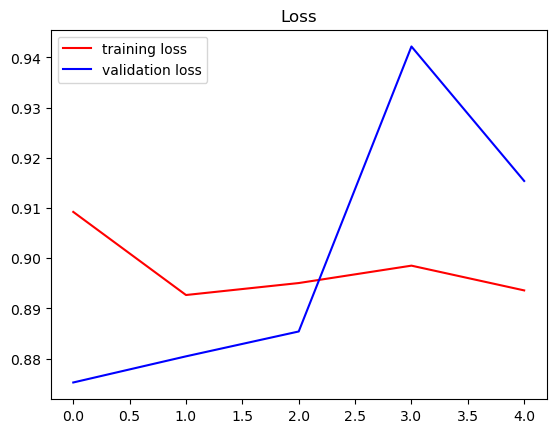

In [58]:
plt.figure()
plt.plot(history.history['loss'], color = 'red', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

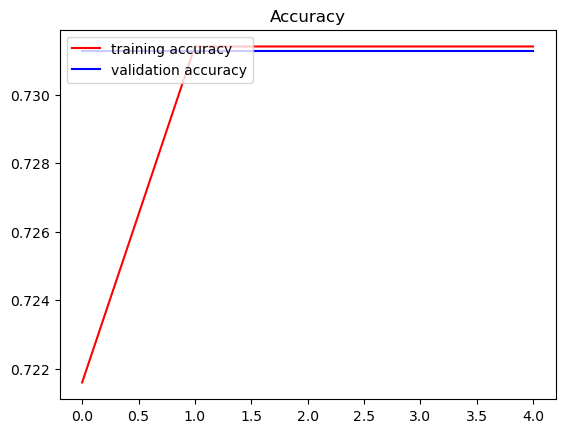

In [59]:
plt.figure()
plt.plot(history.history['accuracy'], color = 'red', label = 'training accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation accuracy')
plt.title('Accuracy')
plt.legend(loc = 'upper left')
plt.show()

**Observation** 

No significant improvement can be seen by transfer learning the dataset on the the pretrained ResNet50 model and therefore a conclusion is made to convert the target of this project to a binary classification model. 

**Conclusion** 

After exploring different parametes for a multi-class CNN model, I have concluded to focus and optimize a binary classification on this dataset. My Binary Classification notebook further dives into optimizing a CNN model for this project my including class weights, image augmentaion only on the minority class and adding layers to my CNN architecture. 